<a href="https://colab.research.google.com/github/mostafaramadann/30Days-of-Remontada/blob/main/Day1/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import torch
from torch.nn import Module,Conv2d,ReLU,MaxPool2d,Sigmoid,BatchNorm2d,UpsamplingBilinear2d
from torch.optim import Adam
from torchsummary import summary
from torch.utils.data import DataLoader
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [85]:
EPOCHS = 30
BATCH_SIZE = 16
DEVICE = "cuda"

In [86]:
import json

!rm -rf /root/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"mostafaramadan","key":"5a78fce93ce75c517d9a06dd5331e662"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [89]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip -q lgg-mri-segmentation.zip

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [88]:
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

In [6]:
df = create_df("kaggle_3m")

In [7]:
def clean_df(df):
  masks_paths=[]
  images_paths=[]

  for i in range(len(df)):
    row = df.iloc[i]
    image_path = row[0]
    mask_path = row[1]
    mask = plt.imread(mask_path)
    image = plt.imread(image_path)
    
    if mask.max() > 0 and image.max() > 0:
      masks_paths.append(mask_path)
      images_paths.append(image_path)
  
  df = pd.DataFrame({"images":images_paths,"masks":masks_paths})
      
  return df

In [90]:
print(len(df))
df = clean_df(df)

1373


In [91]:
print(len(df))

1373


In [94]:
def normalize(image):
  range = image.max()-image.min()
  return (image-image.min())/range 

class SegmentationDataset(torch.utils.data.Dataset):
  def __init__(self,df):
    self.df = df
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self,idx):
    row = df.iloc[idx]
    image = cv2.imread(row[0])
    mask = cv2.imread(row[1])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    
    image = cv2.resize(image,[256,256])
    mask = cv2.resize(mask,[256,256]) 
    
    image = np.transpose(image,(2,0,1))
    mask = np.transpose(np.expand_dims(mask,axis=-1),(2,0,1))
    image, mask = normalize(image),normalize(mask)
    mask = (mask>0.5)*1.0
    return torch.Tensor(image),torch.Tensor(mask)

In [96]:
train_df,test_df = train_test_split(df,test_size=0.2)
test_df,valid_df = train_test_split(test_df,test_size=0.2)

print(len(train_df),len(test_df),len(valid_df))
train_dataset = SegmentationDataset(train_df)
test_dataset = SegmentationDataset(test_df)
valid_dataset = SegmentationDataset(valid_df)

1098 220 55


In [97]:
def vizualise(image,mask):
  fig,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].set_title("Image")
  ax[0].imshow(image,cmap="gray")
  ax[1].set_title("Mask")
  ax[1].imshow(mask,cmap="gray")

1.0 0.0
1.0 0.0


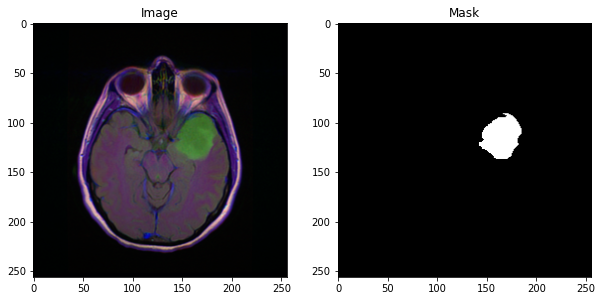

In [112]:
image,mask = train_dataset[1000]
image,mask = np.transpose(image.detach().cpu().numpy(),(1,2,0)),np.transpose(mask.detach().cpu().numpy(),(1,2,0))
vizualise(image,mask)
print(mask.max(),mask.min())
print(image.max(),image.min())


In [113]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [114]:
class ConvBlock(Module):

  def __init__(self,in_channels,out_channels):
    super(ConvBlock,self).__init__()

    self.cv1 = Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),padding="same")
    self.relu1 = ReLU()
    self.bn1 = BatchNorm2d(out_channels)

      
    self.cv2 = Conv2d(in_channels =out_channels ,out_channels=out_channels,kernel_size=(3,3),padding="same")
    self.relu2 = ReLU()
    self.bn2 = BatchNorm2d(out_channels)

  
  def forward(self,x):

    x = self.cv1(x)
    x = self.relu1(x)
    x = self.bn1(x)

    x = self.cv2(x)
    x = self.relu2(x)
    x = self.bn2(x)

    return x

In [115]:
from torch.nn.modules.upsampling import Upsample
class Unet(Module):
  def __init__(self):
    super(Unet,self).__init__()
    self.cbe1 = ConvBlock(3,64)
    self.down1 = MaxPool2d(kernel_size=(2,2),stride=(2,2))

    self.cbe2 = ConvBlock(64,128)
    self.down2 = MaxPool2d(kernel_size=(2,2),stride=(2,2))

    self.cbe3 = ConvBlock(128,256)
    self.down3 = MaxPool2d(kernel_size=(2,2),stride=(2,2))

    self.up1 = UpsamplingBilinear2d(scale_factor=2)

    self.cbd1 = ConvBlock(512,128)
    self.up2 = UpsamplingBilinear2d(scale_factor=2)

    self.cbd2 = ConvBlock(256,64)
    self.up3 = UpsamplingBilinear2d(scale_factor=2)

    self.cbd3 = ConvBlock(128,64)

    self.conv1 = Conv2d(in_channels=64,out_channels=32,kernel_size=(1,1),padding="same")
    self.r1 = ReLU()
    self.bn1 = BatchNorm2d(32)
    self.conv2 = Conv2d(in_channels=32,out_channels=16,kernel_size=(1,1),padding="same")
    self.r2 = ReLU()

    self.conv3 = Conv2d(in_channels=16,out_channels=1,kernel_size=(1,1),padding="same")

    self.sig = Sigmoid()

  def forward(self,x):
    ##encoder
    c1 = self.cbe1(x)
    x = self.down1(c1)

    c2 = self.cbe2(x)
    x = self.down2(c2)

    c3 = self.cbe3(x)
    x = self.down3(c3)

    ## decoder
    x = self.up1(x)
    x = torch.cat((x,c3),1)
    x = self.cbd1(x)
    x = self.up2(x)

    x = torch.cat((x,c2),1)
    x = self.cbd2(x)
    x = self.up3(x)


    x = torch.cat((x,c1),1)
    x = self.cbd3(x)

    x = self.conv1(x)
    x = self.r1(x)

    x = self.conv2(x)
    x = self.r2(x)

    x = self.conv3(x)
    x = self.sig(x)

    return x


In [147]:
model = Unet()
summary(model.cuda(),(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         ConvBlock-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
             ReLU-10        [-1, 128, 128, 128]               0
      BatchNorm2d-11        [-1, 128, 128, 128]             256
           Conv2d-12        [-1, 128, 128, 128]         147,584
             ReLU-13        [-1, 128, 128, 128]               0
      BatchNorm2d-14        [-1, 128, 1

  0%|          | 0/69 [00:00<?, ?it/s]

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
(16, 3, 256, 256) (16, 1, 256, 256)


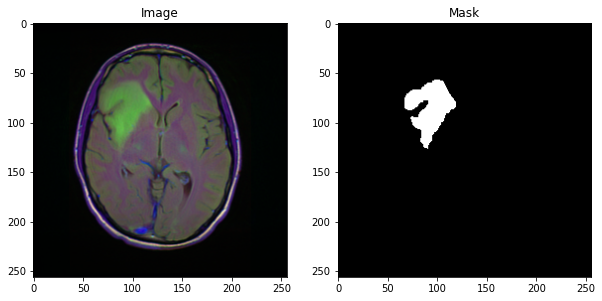

In [148]:
for (x,y) in tqdm(train_loader):
  break
print(x.size(),y.size())
print(y.min(),y.max())
print(x.min(),x.max())
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
print(x.shape,y.shape)
image,mask = np.transpose(x,(0,2,3,1)),np.transpose(y,(0,2,3,1))
vizualise(image[0],mask[0])

In [149]:
def seg_loss(pred,target):
  def dice_loss():
    
    smooth = 0.2
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
      
    return 1 - ((2.*intersection + smooth) / (A_sum + B_sum + smooth) )
  
  loss1 = torch.nn.BCELoss()(pred,target)
  loss2 = dice_loss()
  return loss1

In [150]:
optimizer = Adam(model.parameters(), lr=0.003)
loss_fn = seg_loss

In [151]:
def train_fn(data_loader,model,optimizer,loss_fn):

  model.train()
  total_loss = 0.0
  for (x,y) in tqdm(data_loader):

    x,y = x.to(DEVICE),y.to(DEVICE)
    y_hat = model(x)
    loss = loss_fn(y_hat,y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()

  return total_loss/len(data_loader)

def valid_fn(data_loader,model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      y_hat = model(images)
      loss = loss_fn(y_hat,masks)

      total_loss +=loss.item()
      
  return total_loss/len(data_loader)

In [152]:
train_loss = []
for i in range(EPOCHS):
  loss = train_fn(train_loader,model,optimizer,loss_fn)
  train_loss.append(loss)
  valid_loss = valid_fn(valid_loader,model)
  print(f"epoch {i} train loss is {loss} , valid loss is {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


epoch 0 train loss is 0.14646066520093143 , valid loss is 0.12126983888447285


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


epoch 1 train loss is 0.05652076939957729 , valid loss is 0.0717566516250372


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


epoch 2 train loss is 0.055815735480923584 , valid loss is 0.06580822635442019


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


epoch 3 train loss is 0.050577604927230575 , valid loss is 0.12448402121663094


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


epoch 4 train loss is 0.05035058476462744 , valid loss is 0.05499862227588892


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


epoch 5 train loss is 0.04792253689273544 , valid loss is 0.055262754671275616


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


epoch 6 train loss is 0.046685428939003876 , valid loss is 0.07329540979117155


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


epoch 7 train loss is 0.047578678128943924 , valid loss is 0.056467266753315926


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


epoch 8 train loss is 0.046975676348243935 , valid loss is 0.05918081384152174


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


epoch 9 train loss is 0.04485210104157095 , valid loss is 0.0675126938149333


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


epoch 10 train loss is 0.042893041762104935 , valid loss is 0.051732185296714306


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


epoch 11 train loss is 0.04451463546981846 , valid loss is 0.04972803872078657


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


epoch 12 train loss is 0.043160378474040306 , valid loss is 0.10640071518719196


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


epoch 13 train loss is 0.03964001167079677 , valid loss is 0.06957874447107315


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


epoch 14 train loss is 0.038034694458263504 , valid loss is 0.05572688207030296


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


epoch 15 train loss is 0.03618393028559892 , valid loss is 0.05641534738242626


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


epoch 16 train loss is 0.03346467458143614 , valid loss is 0.047438113018870354


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


epoch 17 train loss is 0.034946836207223976 , valid loss is 0.06757005862891674


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


epoch 18 train loss is 0.03450815190655598 , valid loss is 0.04964108858257532


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


epoch 19 train loss is 0.031873772352717926 , valid loss is 0.049204226583242416


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


epoch 20 train loss is 0.031450346166241 , valid loss is 0.0570565527305007


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


epoch 21 train loss is 0.030602197446252987 , valid loss is 0.04561154730618


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


epoch 22 train loss is 0.028202488343568817 , valid loss is 0.06373257655650377


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


epoch 23 train loss is 0.027726089662831764 , valid loss is 0.04519533831626177


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


epoch 24 train loss is 0.026376000807985016 , valid loss is 0.03255209932103753


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


epoch 25 train loss is 0.026068707320677197 , valid loss is 0.08942299243062735


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


epoch 26 train loss is 0.02537187426418498 , valid loss is 0.040549914352595806


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


epoch 27 train loss is 0.023969672971229622 , valid loss is 0.050202544778585434


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


epoch 28 train loss is 0.02345742926379477 , valid loss is 0.03486132249236107


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

epoch 29 train loss is 0.022508423154552776 , valid loss is 0.03356812382116914


In [153]:
with torch.no_grad():
  for (x,y) in valid_loader:
    x,y = x.to(DEVICE),y.to(DEVICE)
    y_hat = model(x)
    x = x.detach().cpu().numpy()
    y_hat = y_hat.detach().cpu().numpy()
    break

x = np.transpose(x,(0,2,3,1))
y_hat = np.transpose(y_hat,(0,2,3,1))

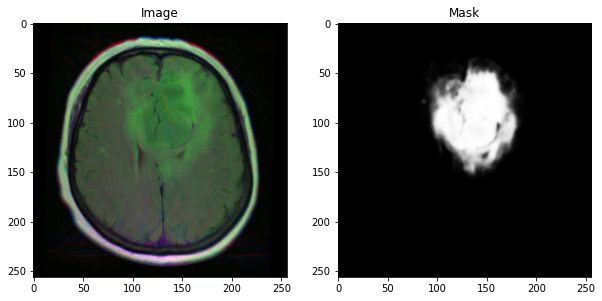

In [162]:
vizualise(x[10],y_hat[10])

In [ ]:
# class ConvBlock(Module):
#   def __init__(self,filters,upsample=None,last=False):
#     self.last = last
#     super(ConvBlock,self).__init__()
#     self.conv1 = Conv2d(in_channels=filters[0][0],out_channels=filters[0][1],kernel_size=(3,3),padding="same")
#     self.relu1 = ReLU()
#     self.conv2 = Conv2d(in_channels=filters[1][0],out_channels=filters[1][1],kernel_size=(3,3),padding="same")
#     self.relu2= ReLU()
    
#     if upsample:
#       self.llayer = ConvTranspose2d(in_channels=filters[1][1],out_channels=filters[1][1],kernel_size=(2,2),stride=2)
#     else:
#       self.llayer = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

#   def forward(self,x,concat = None):
#     if concat is not None:
#       x = torch.cat((x,concat),1)

#     x = self.conv1(x)
#     x = self.relu1(x)
#     x = self.conv2(x)
#     c = self.relu2(x)
#     if not self.last:
#       x = self.llayer(c)

#     if concat is not None:
#       return x
#     return x,c

In [ ]:
# class Encoder(Module):
#   def __init__(self,filters,in_channels=3):
#     super(Encoder,self).__init__()
#     self.cb1 = ConvBlock(filters[0])
#     self.bn1 = BatchNorm2d(32)
#     self.cb2 = ConvBlock(filters[1])
#     self.bn2 = BatchNorm2d(64)
#     self.cb3 = ConvBlock(filters[2])
#     self.bn3 = BatchNorm2d(128)
#     self.cb4 = ConvBlock(filters[3])
#     self.bn4 = BatchNorm2d(256)
#     self.cb5 = ConvBlock(filters[4])
#     self.bn5 = BatchNorm2d(512)
#     self.cb6 = ConvBlock(filters[5])

#   def forward(self,x):
#     x,c1 = self.cb1(x)
#     x = self.bn1(x)
#     x,c2 = self.cb2(x)
#     x = self.bn2(x)
#     x,c3 = self.cb3(x)
#     x = self.bn3(x)
#     x,c4 = self.cb4(x)
#     x = self.bn4(x)
#     x,c5 = self.cb5(x)
#     x = self.bn5(x)
#     x,c6 = self.cb6(x)

#     return x,c1,c2,c3,c4,c5,c6

In [ ]:
# class Decoder(Module):

#   def __init__(self,filters,in_channels = 256):
#     super(Decoder,self).__init__()
#     self.cb1  = ConvBlock(filters[0],upsample=True)
#     self.bn1 = BatchNorm2d(512)
#     self.cb2  = ConvBlock(filters[1],upsample=True)
#     self.bn2 = BatchNorm2d(256)
#     self.cb3  = ConvBlock(filters[2],upsample=True)
#     self.bn3 = BatchNorm2d(128)
#     self.cb4  = ConvBlock(filters[3],upsample=True)
#     self.bn4 = BatchNorm2d(64)
#     self.cb5  = ConvBlock(filters[4],upsample=True)
#     self.bn5 = BatchNorm2d(32)
#     self.cb6  = ConvBlock(filters[5],upsample=True,last=True)

#   def forward(self,x,c):
#     x = self.cb1(x,c[0])
#     x = self.bn1(x)
#     x = self.cb2(x,c[1])
#     x = self.bn2(x)
#     x = self.cb3(x,c[2])
#     x = self.bn3(x)
#     x = self.cb4(x,c[3])
#     x = self.bn4(x)
#     x = self.cb5(x,c[4])
#     x = self.bn5(x)
#     x = self.cb6(x,c[5])

#     return x

In [ ]:
# class Unet(Module):
#   def __init__(self,filters_enc,filters_dec):

#     super(Unet,self).__init__()
#     self.enc = Encoder(filters_enc)
#     self.upsample = ConvTranspose2d(in_channels=1024,out_channels=1024,kernel_size=(2,2),stride=2)
#     self.dec = Decoder(filters_dec,in_channels=1024)
#     self.conv1 = Conv2d(in_channels=16,out_channels=1,kernel_size=(1,1))
#     self.sig = Sigmoid()

#   def forward(self,x):
#     x,c1,c2,c3,c4,c5,c6 = self.enc(x)
#     x = self.upsample(x)
#     x = self.dec(x,[c6,c5,c4,c3,c2,c1])
#     x = self.conv1(x)
#     x = self.sig(x)
#     return x

In [ ]:
# filters_enc = [
#                 [[3,32], ## cb1
#                 [32,32]],
        
#                 [[32,64],## cb2
#                 [64,64]],
               
#                 [[64,128], ## cb3 
#                  [128,128]], 
               
#                  [[128,256], ## cb4
#                   [256,256]],
               
#                 [[256,512], ## cb5
#                 [512,512]],
                
#                 [[512,1024], ## cb6
#                 [1024,1024]]
            
#                ]

# filters_dec = [
#                 [[2048,1024],#cb1
#                 [1024,512]],
               
#                [[1024,512],#cb2
#                 [512,256]],
               
#                [[512,256],#cb3
#                 [256,128]],
               
#                [[256,128],#cb4
#                 [128,64]],
               
#                 [[128,64],#cb5
#                 [64,32]],
              
#                 [[64,32],#cb6
#                 [32,16]]
               
#                ]
               

# model = Unet(filters_enc,filters_dec)
# summary(model.cuda(),(3,256,256))